In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

def unpack_params(params, shapes, dtypes):
    """Unpack params back into matrices with given shapes and dtypes."""
    idx = 0
    matrices = []
    for shape, dtype in zip(shapes, dtypes):
        size = np.prod(shape)
        values = params[idx:idx + size]
        matrix = values.reshape(shape).astype(dtype)
        matrices.append(matrix)
        idx += size
    return matrices

def sample_uniform_frequencies_1d(n, bound=0.5):
    # Calculer le nombre de points dans chaque dimension
    N = 2 * n + 1
    # Générer une grille uniforme de points entre -0.5 et 0.5
    #bound = 8
    grid_1d = np.linspace(-bound, bound, N)
    return grid_1d

class Gauss1D():

  def __init__(self, n=0, sigma=1):
    self.n = n
    self.sigma = sigma

    self.g_ = np.array([])
    self.g()

  def fourier(self, w):
    return np.exp(-2 * (w * self.sigma * np.pi)**2)

  def g(self):
    if len(self.g_) == 0:
      freqs = sample_uniform_frequencies_1d(self.n)
      self.g_ = np.array([self.fourier(f) for f in freqs])
    return self.g_

  def compute(self, t):
    t_array = np.array(t)
    return (1/(self.sigma*np.sqrt(2*np.pi))) * np.exp(-t_array**2/(2* self.sigma**2))

  def computeK(self, t):
    t = np.array(t)
    freqs = sample_uniform_frequencies_1d(self.n)
    if len(t.shape) == 0:
        return np.sum(np.abs(self.g())**2 * np.exp(2j * np.pi * freqs * t))
    V = np.exp(2j * np.pi * np.outer(freqs, t))
    return np.sum(np.abs(self.g())**2 * V.T, axis=1).reshape(t.shape)

  def computeK_p(self, t):
      t = np.array(t)
      freqs = sample_uniform_frequencies_1d(self.n)
      if len(t.shape) == 0:
          return np.sum(2j * np.pi * freqs * np.abs(self.g())**2 * np.exp(2j * np.pi * freqs * t))
      V = np.exp(2j * np.pi * np.outer(freqs, t))
      return np.sum(np.abs(self.g())**2 * (2j * np.pi * freqs) * V.T, axis=1).reshape(t.shape)

  def computeK_pp(self, t):
      t = np.array(t)
      freqs = sample_uniform_frequencies_1d(self.n)
      if len(t.shape) == 0:
          return np.sum((2j * np.pi * freqs)**2 * np.abs(self.g())**2 * np.exp(2j * np.pi * freqs * t))
      V = np.exp(2j * np.pi * np.outer(freqs, t))
      return np.sum(np.abs(self.g())**2 * (2j * np.pi * freqs)**2 * V.T, axis=1).reshape(t.shape)

  def computeK_pp0(self):
      return self.computeK_pp(0)

In [13]:
def compute_z(a, tau, g, freqs):
    r = len(tau)
    z = np.zeros(len(freqs), dtype=complex)  # Initialize z with complex numbers

    for k in range(len(freqs)):  # Loop over dimension len(freqs)
        z[k] = np.sum([a[j] * g[k] * np.exp(2j * np.pi * tau[j] * freqs[k]) for j in range(r)])

    return z

def grad_approx_perso(kernel, theta_pred, data_observed, freqs):

        r = int(len(theta_pred)/2)
        a = theta_pred[:r]
        tau = theta_pred[r:]
        grad = np.zeros(2*r, dtype=complex)

        tau_matrix = np.tile(tau, (r,1)).T
        tau_diff_matrix = tau_matrix - tau_matrix.T

        k_matrix = np.array([kernel.computeK(tau_diff_matrix)])[0]
        kp_matrix = np.array([kernel.computeK_p(tau_diff_matrix)])[0]

        kernel_g = np.conj(kernel.g()).reshape(-1,1)
        exp_term = np.exp(-2j*np.pi*np.outer(tau,freqs))
        freqs = freqs.reshape(-1,1)

        for j in range(r):
            grad[j] = np.sum(theta_pred[:r]*k_matrix[j]) - np.sum(kernel_g*data_observed*(exp_term[j].reshape(-1,1)))
            grad[j+r] = np.real(np.conj(a[j]) * np.sum(theta_pred[:r]*kp_matrix[j])) - np.real(np.conj(a[j]) * np.sum(kernel_g*data_observed*-2j*np.pi*freqs*(exp_term[j].reshape(-1,1))))

        return grad

In [14]:
def add_noise(y_current, snr_db):
    # Calcul de la puissance du signal
    signal_power = np.mean(np.abs(y_current)**2)

    # Conversion du SNR de dB à linéaire
    snr_linear = 10**(snr_db/10)

    # Calcul de la puissance du bruit
    noise_power = signal_power / snr_linear

    # Génération du bruit (pour un signal complexe)
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_current.shape) + 1j*np.random.randn(*y_current.shape))

    # Signal bruité
    y_noisy = y_current + noise
    return y_noisy

In [15]:
# Loss function
def MSE_loss(params, y_current):
    shapes = [(r), (r)]  # Add dtype if needed
    dtypes = [complex, complex]
    a, tau = unpack_params(params, shapes, dtypes)
    z = compute_z(a, tau, g_star, freqs).reshape(-1,1)
    return 0.5 * np.linalg.norm(y_current - z) ** 2

# Preconditioned gradient descent function
def preconditioned_gradient_descent(loss_func, initial_point, y_current, learning_rate=0.01, momentum=0.9, max_iters=200):
    point = np.array(initial_point, dtype=float)
    velocity = np.zeros_like(point)
    loss_values = []
    for i in range(max_iters):
        gradient = grad_approx_perso(kernel, point, y_current, freqs).real
        a = point[:r]
        velocity = momentum * velocity - learning_rate * P_k(a) @ gradient
        point = point + velocity
        #point[:r] = np.abs(point[:r])
        loss = loss_func(point, y_current)
        loss_values.append(loss)
    return point, loss_values

In [16]:
n=7
N=2*n+1

freqs = sample_uniform_frequencies_1d(n)

tau_star = np.array([-6, -3, 5])  # Moyennes des gaussiennes
a_star = np.array([0.1, 0.1, 0.8])   # Amplitudes/proportions des gaussiennes
sigma=1
theta_star = np.concatenate((a_star, tau_star))
r = len(tau_star)
kernel = Gauss1D(n, sigma)

g_star = kernel.fourier(freqs) + 0j
y_star = compute_z(a_star, tau_star, g_star, freqs)

S_err = lambda theta : np.max([np.abs(theta[:r] - theta_star[:r])/np.abs(theta_star[:r]), np.sqrt(np.abs(kernel.computeK_pp0()))*np.abs(theta[r:] - theta_star[r:])])

F_second = np.abs(kernel.computeK_pp0())
def P_k(a):
  return np.diag(np.concatenate( [np.ones(len(a)), (1/F_second) * (np.abs(a)**-2)] ))

theta_vanilla: [ 0.09925046  0.10044822  0.79965786 -6.02632194 -3.05299735  4.9990702 ]
theta_momentum: [ 0.09991618  0.10017148  0.79984399 -6.01033117 -3.00873512  4.99955006]
theta_preconditioned: [ 0.1         0.10000064  0.79999936 -6.0000362  -3.00002304  4.99999712]
theta_mom_prec: [ 0.1         0.10000006  0.79999994 -6.00000344 -3.00000219  4.99999973]


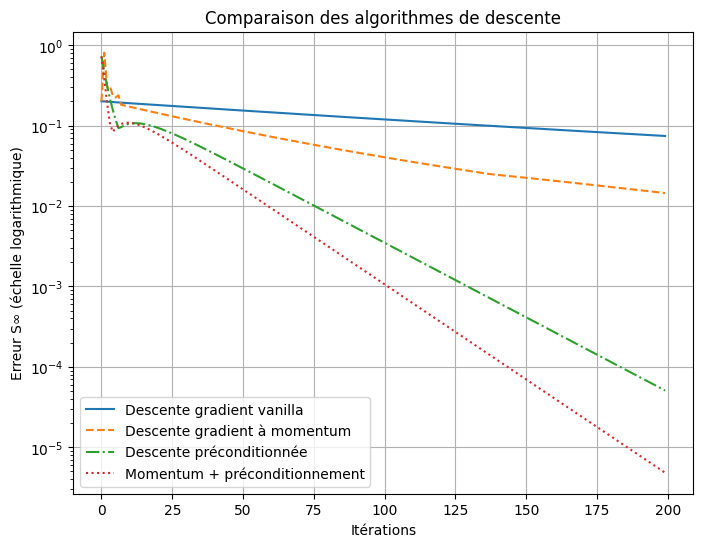

In [17]:
import numpy as np
import matplotlib.pyplot as plt

initial_point = theta_star + np.random.randn(2*r) * 0.1
y_current = y_star

# --- Define the S_infty norm error as loss function ---
# This loss function ignores the second argument (y_current) since the error is computed only from theta.
S_err_wrapper = lambda theta, y: np.max([
    np.abs(theta[:r] - theta_star[:r]) / np.abs(theta_star[:r]),
    np.sqrt(np.abs(kernel.computeK_pp0())) * np.abs(theta[r:] - theta_star[r:])
])


# --- Save the original preconditioner ---
P_k_original = P_k

# --- Define an identity preconditioner to simulate "no preconditioning" ---
def identity_P_k(a):
    return np.eye(2*len(a))

# --- Experiment parameters ---
max_iters = 200

# --- Experiment 1: Vanilla (no momentum, no preconditioning) ---
# Override P_k to be the identity.
P_k = identity_P_k
theta_vanilla, loss_vanilla = preconditioned_gradient_descent(
    S_err_wrapper, initial_point, y_current.reshape(-1, 1),
    learning_rate=0.3, momentum=0, max_iters=max_iters
)

# --- Experiment 2: Gradient descent with momentum (momentum, no preconditioning) ---
P_k = identity_P_k  # still no preconditioning
theta_momentum, loss_momentum = preconditioned_gradient_descent(
    S_err_wrapper, initial_point, y_current.reshape(-1, 1),
    learning_rate=0.3, momentum=0.7, max_iters=max_iters
)

# --- Experiment 3: Preconditioned gradient descent (no momentum, with preconditioning) ---
P_k = P_k_original  # restore the original preconditioner
theta_preconditioned, loss_preconditioned = preconditioned_gradient_descent(
    S_err_wrapper, initial_point, y_current.reshape(-1, 1),
    learning_rate=0.1, momentum=0, max_iters=max_iters
)

# --- Experiment 4: Momentum + Preconditioning (momentum, with preconditioning) ---
P_k = P_k_original
theta_mom_prec, loss_mom_prec = preconditioned_gradient_descent(
    S_err_wrapper, initial_point, y_current.reshape(-1, 1),
    learning_rate=0.1, momentum=0.2, max_iters=max_iters
)

print("theta_vanilla:", theta_vanilla)
print("theta_momentum:", theta_momentum)
print("theta_preconditioned:", theta_preconditioned)
print("theta_mom_prec:", theta_mom_prec)


# --- Plotting the evolution of S_infty error ---
iters = np.arange(max_iters)

plt.figure(figsize=(8, 6))

# Récupération du cycle de couleurs par défaut
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Définition des linestyles et des markers pour chaque tracé
linestyles = ['-', '--', '-.', ':']
#markers = ['o', 's', '^', 'd']

# Tracés individuels avec semilogy (permettant de voir les différences de style)
plt.semilogy(iters, loss_vanilla, linestyle=linestyles[0], color=colors[0],
             label="Descente gradient vanilla")
plt.semilogy(iters, loss_momentum, linestyle=linestyles[1], color=colors[1],
             label="Descente gradient à momentum")
plt.semilogy(iters, loss_preconditioned, linestyle=linestyles[2], color=colors[2],
             label="Descente préconditionnée")
plt.semilogy(iters, loss_mom_prec, linestyle=linestyles[3], color=colors[3],
             label="Momentum + préconditionnement")

plt.xlabel("Itérations")
plt.ylabel("Erreur S∞ (échelle logarithmique)")
plt.title("Comparaison des algorithmes de descente")
plt.legend()
plt.grid(True)

plt.show()

# --- Restore the original preconditioner if needed ---
P_k = P_k_original

In [18]:
import numpy as np
import matplotlib.pyplot as plt

n_trials = 100      # nombre de trajectoires
max_iters = 200    # nombre d'itérations

# Listes pour stocker les pertes de chaque trajectoire
loss_vanilla_trials = []
loss_momentum_trials = []
loss_preconditioned_trials = []
loss_mom_prec_trials = []

for trial in range(n_trials):
    # On génère un point initial différent pour chaque trajectoire
    delta = np.random.randn(2*r)
    current_norm = S_err(theta_star + delta)
    scale = 0.1 / current_norm if current_norm != 0 else 0.0
    initial_point = theta_star + scale * delta
    #initial_point = theta_star + np.random.randn(2*r) * 0.01
    y_current = y_star  # on garde y_star inchangé

    # --- Expérience 1 : Descente gradient vanilla (pas de momentum, pas de préconditionnement) ---
    P_k = identity_P_k  # utilisation de l'identité
    theta_vanilla, loss_vanilla = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.3, momentum=0, max_iters=max_iters
    )
    loss_vanilla_trials.append(loss_vanilla)

    # --- Expérience 2 : Descente gradient avec momentum (momentum, pas de préconditionnement) ---
    P_k = identity_P_k
    theta_momentum, loss_momentum = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.3, momentum=0.7, max_iters=max_iters
    )
    loss_momentum_trials.append(loss_momentum)

    # --- Expérience 3 : Descente préconditionnée (pas de momentum, avec préconditionnement) ---
    P_k = P_k_original
    theta_preconditioned, loss_preconditioned = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.1, momentum=0, max_iters=max_iters
    )
    loss_preconditioned_trials.append(loss_preconditioned)

    # --- Expérience 4 : Momentum + préconditionnement (momentum, avec préconditionnement) ---
    P_k = P_k_original
    theta_mom_prec, loss_mom_prec = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.1, momentum=0.2, max_iters=max_iters
    )
    loss_mom_prec_trials.append(loss_mom_prec)

# Convertir les listes en tableaux NumPy pour calculer la moyenne et l'écart-type
loss_vanilla_trials = np.array(loss_vanilla_trials)
loss_momentum_trials = np.array(loss_momentum_trials)
loss_preconditioned_trials = np.array(loss_preconditioned_trials)
loss_mom_prec_trials = np.array(loss_mom_prec_trials)

iters = np.arange(max_iters)

# Calcul des moyennes et écarts-types pour chaque méthode
mean_vanilla = np.mean(loss_vanilla_trials, axis=0)
std_vanilla = np.std(loss_vanilla_trials, axis=0)

mean_momentum = np.mean(loss_momentum_trials, axis=0)
std_momentum = np.std(loss_momentum_trials, axis=0)

mean_preconditioned = np.mean(loss_preconditioned_trials, axis=0)
std_preconditioned = np.std(loss_preconditioned_trials, axis=0)

mean_mom_prec = np.mean(loss_mom_prec_trials, axis=0)
std_mom_prec = np.std(loss_mom_prec_trials, axis=0)

# --- Restaurer le préconditionneur original si nécessaire ---
P_k = P_k_original

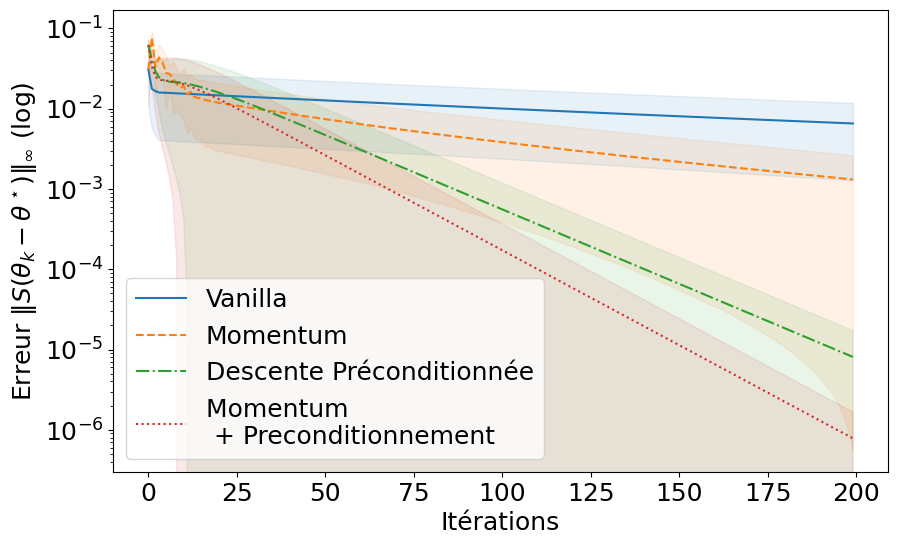

In [19]:
# --- Affichage ---
size = 18


#plt.figure(figsize=(8, 6))
plt.figure(figsize=(10, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Descente gradient vanilla
plt.semilogy(iters, mean_vanilla, linestyle='-', color=colors[0],
             label="Vanilla")
plt.fill_between(iters, mean_vanilla - std_vanilla, mean_vanilla + std_vanilla,
                 color=colors[0], alpha=0.1)

# Descente gradient à momentum
plt.semilogy(iters, mean_momentum, linestyle='--', color=colors[1],
             label="Momentum")
plt.fill_between(iters, mean_momentum - std_momentum, mean_momentum + std_momentum,
                 color=colors[1], alpha=0.1)

# Descente préconditionnée
plt.semilogy(iters, mean_preconditioned, linestyle='-.', color=colors[2],
             label="Descente Préconditionnée")
plt.fill_between(iters, mean_preconditioned - std_preconditioned, mean_preconditioned + std_preconditioned,
                 color=colors[2], alpha=0.1)

# Momentum + préconditionnement
plt.semilogy(iters, mean_mom_prec, linestyle=':', color=colors[3],
             label="Momentum \n + Preconditionnement")
plt.fill_between(iters, mean_mom_prec - std_mom_prec, mean_mom_prec + std_mom_prec,
                 color=colors[3], alpha=0.1)


plt.xlabel("Itérations", fontsize=size)
plt.ylabel(r"Erreur $\| S ({\theta}_k - \theta^\star) \|_{\infty}$ (log)", fontsize=size)
#plt.title(f"Comparaison des algorithmes de descente (moyenne et écart-type sur {n_trials} trajectoires)", fontsize=16)
plt.legend()
#plt.grid(True)


plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=size)

# Save the figure as a PDF
pdf_filename = "/content/CompSpeedMoy.pdf"
plt.savefig(pdf_filename, format="pdf")
plt.show()

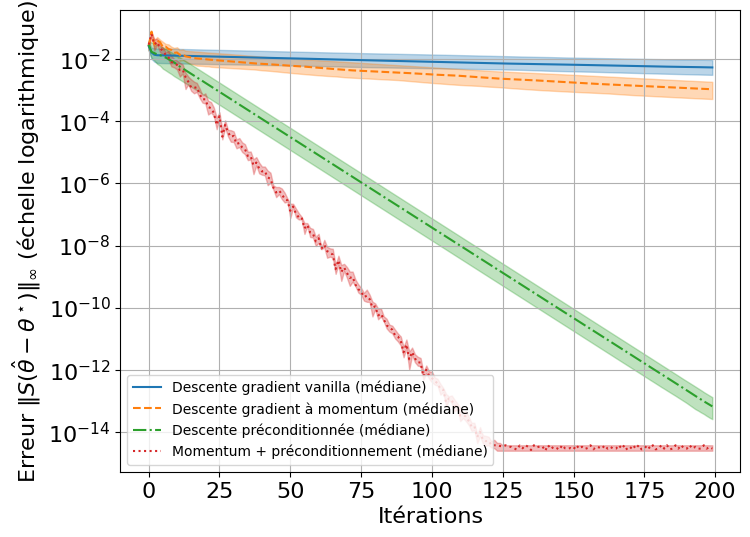

In [9]:
import numpy as np
import matplotlib.pyplot as plt

n_trials = 100     # nombre de trajectoires
max_iters = 200    # nombre d'itérations

# Listes pour stocker les pertes de chaque trajectoire
loss_vanilla_trials = []
loss_momentum_trials = []
loss_preconditioned_trials = []
loss_mom_prec_trials = []

for trial in range(n_trials):
    # On génère un point initial différent pour chaque trajectoire
    delta = np.random.randn(2*r)
    current_norm = S_err(theta_star + delta)
    scale = 0.1 / current_norm if current_norm != 0 else 0.0
    initial_point = theta_star + scale * delta
    #initial_point = theta_star + np.random.randn(2*r) * 0.01
    y_current = y_star  # on garde y_star inchangé

    # --- Expérience 1 : Descente gradient vanilla ---
    P_k = identity_P_k
    theta_vanilla, loss_vanilla = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.3, momentum=0, max_iters=max_iters
    )
    loss_vanilla_trials.append(loss_vanilla)

    # --- Expérience 2 : Descente gradient avec momentum ---
    P_k = identity_P_k
    theta_momentum, loss_momentum = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.3, momentum=0.7, max_iters=max_iters
    )
    loss_momentum_trials.append(loss_momentum)

    # --- Expérience 3 : Descente préconditionnée ---
    P_k = P_k_original
    theta_preconditioned, loss_preconditioned = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.3, momentum=0, max_iters=max_iters
    )
    loss_preconditioned_trials.append(loss_preconditioned)

    # --- Expérience 4 : Momentum + préconditionnement ---
    P_k = P_k_original
    theta_mom_prec, loss_mom_prec = preconditioned_gradient_descent(
        S_err_wrapper, initial_point, y_current.reshape(-1, 1),
        learning_rate=0.3, momentum=0.6, max_iters=max_iters
    )
    loss_mom_prec_trials.append(loss_mom_prec)

# Conversion des listes en tableaux NumPy
loss_vanilla_trials = np.array(loss_vanilla_trials)
loss_momentum_trials = np.array(loss_momentum_trials)
loss_preconditioned_trials = np.array(loss_preconditioned_trials)
loss_mom_prec_trials = np.array(loss_mom_prec_trials)

iters = np.arange(max_iters)

# Calcul de la médiane et des quartiles (25ème et 75ème percentiles) pour chaque méthode

# Descente gradient vanilla
median_vanilla = np.median(loss_vanilla_trials, axis=0)
q1_vanilla = np.percentile(loss_vanilla_trials, 25, axis=0)
q3_vanilla = np.percentile(loss_vanilla_trials, 75, axis=0)

# Descente gradient à momentum
median_momentum = np.median(loss_momentum_trials, axis=0)
q1_momentum = np.percentile(loss_momentum_trials, 25, axis=0)
q3_momentum = np.percentile(loss_momentum_trials, 75, axis=0)

# Descente préconditionnée
median_preconditioned = np.median(loss_preconditioned_trials, axis=0)
q1_preconditioned = np.percentile(loss_preconditioned_trials, 25, axis=0)
q3_preconditioned = np.percentile(loss_preconditioned_trials, 75, axis=0)

# Momentum + préconditionnement
median_mom_prec = np.median(loss_mom_prec_trials, axis=0)
q1_mom_prec = np.percentile(loss_mom_prec_trials, 25, axis=0)
q3_mom_prec = np.percentile(loss_mom_prec_trials, 75, axis=0)

# --- Affichage ---
plt.figure(figsize=(8, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Descente gradient vanilla
plt.semilogy(iters, median_vanilla, linestyle='-', color=colors[0],
             label="Descente gradient vanilla (médiane)")
plt.fill_between(iters, q1_vanilla, q3_vanilla,
                 color=colors[0], alpha=0.3)

# Descente gradient à momentum
plt.semilogy(iters, median_momentum, linestyle='--', color=colors[1],
             label="Descente gradient à momentum (médiane)")
plt.fill_between(iters, q1_momentum, q3_momentum,
                 color=colors[1], alpha=0.3)

# Descente préconditionnée
plt.semilogy(iters, median_preconditioned, linestyle='-.', color=colors[2],
             label="Descente préconditionnée (médiane)")
plt.fill_between(iters, q1_preconditioned, q3_preconditioned,
                 color=colors[2], alpha=0.3)

# Momentum + préconditionnement
plt.semilogy(iters, median_mom_prec, linestyle=':', color=colors[3],
             label="Momentum + préconditionnement (médiane)")
plt.fill_between(iters, q1_mom_prec, q3_mom_prec,
                 color=colors[3], alpha=0.3)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)



plt.xlabel("Itérations", fontsize=16)
plt.ylabel(r"Erreur $\| S (\hat{\theta} - \theta^\star) \|_{\infty}$ (échelle logarithmique)", fontsize=16)
#plt.title(f'Comparaison des algorithmes de descente\nMédiane et intervalle interquartile sur {n_trials} trajectoires')
plt.legend()
plt.grid(True)
plt.show()

# --- Restaurer le préconditionneur original si nécessaire ---
P_k = P_k_original

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de l'algorithme de descente
max_iters = 400
learning_rate = 0.1
threshold = 1e-2  # Seuil de convergence sur S_infty

# ----- Paramètres de l'expérience -----
# On étudie des distances S_norm allant de 0.1 à 1
nb_distances = 10  # par exemple, 10 valeurs
distances = np.linspace(0.01, 1.5, nb_distances)
nb_experiences = 30  # 10 points aléatoires par distance

# On prépare une structure pour stocker le taux de convergence pour chaque méthode
# Les méthodes seront : Vanilla, Momentum, Préconditionnée, Momentum+Préconditionnement
methods = ["Vanilla", "Momentum", "Preconditioned", "Momentum+Preconditioned"]
convergence_rates = {m: [] for m in methods}


# ----- Boucle sur les distances -----
for d in distances:
    # compteur de convergences pour chaque méthode (sur nb_experiences)
    counts = {m: 0 for m in methods}

    for _ in range(nb_experiences):
        # Génération d'un point initial à distance d de theta_star
        # On génère un vecteur aléatoire delta dans R^(2r) et on le redimensionne.
        delta = np.random.randn(2*r)
        current_norm = S_err(theta_star + delta)
        scale = d / current_norm if current_norm != 0 else 0.0
        theta_init = theta_star + scale * delta

        # Pour chaque méthode, on réinitialise le point de départ
        # et on configure le préconditionneur et le momentum.

        # 1. Vanilla (pas de momentum, pas de préconditionnement)
        P_k = identity_P_k  # on définit le préconditionneur comme identité
        theta_final, loss_history = preconditioned_gradient_descent(
            S_err_wrapper, theta_init, y_star.reshape(-1, 1),
            learning_rate=learning_rate, momentum=0, max_iters=max_iters
        )
        if loss_history[-1] < threshold:
            counts["Vanilla"] += 1

        # 2. Avec momentum (momentum, pas de préconditionnement)
        P_k = identity_P_k
        theta_final, loss_history = preconditioned_gradient_descent(
            S_err_wrapper, theta_init, y_star.reshape(-1, 1),
            learning_rate=learning_rate, momentum=0.7, max_iters=max_iters
        )
        if loss_history[-1] < threshold:
            counts["Momentum"] += 1

        # 3. Préconditionnée (pas de momentum, avec préconditionnement)
        P_k = P_k_original  # ici P_k_original, tel que défini plus haut
        theta_final, loss_history = preconditioned_gradient_descent(
            S_err_wrapper, theta_init, y_star.reshape(-1, 1),
            learning_rate=learning_rate, momentum=0, max_iters=max_iters
        )
        if loss_history[-1] < threshold:
            counts["Preconditioned"] += 1

        # 4. Momentum + Préconditionnement (momentum, avec préconditionnement)
        P_k = P_k_original
        theta_final, loss_history = preconditioned_gradient_descent(
            S_err_wrapper, theta_init, y_star.reshape(-1, 1),
            learning_rate=learning_rate, momentum=0.6, max_iters=max_iters
        )
        if loss_history[-1] < threshold:
            counts["Momentum+Preconditioned"] += 1

    # Calcul du taux de convergence (en fraction) pour chaque méthode à la distance d
    for m in methods:
        convergence_rates[m].append(counts[m] / nb_experiences)

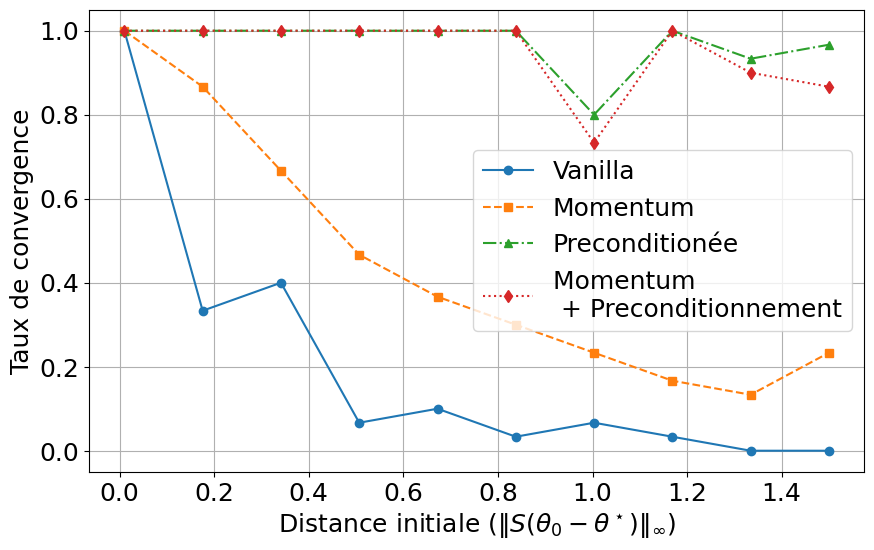

In [21]:
# ----- Visualisation des résultats -----
size = 18

#plt.figure(figsize=(8,6))
plt.figure(figsize=(10, 6))

# Récupération du cycle de couleurs par défaut
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Définition des linestyles et des markers pour chaque tracé
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd']
methodes = ["Vanilla", "Momentum", "Preconditionée", "Momentum \n + Preconditionnement"] # en français
for i, m in enumerate(methods):
    plt.plot(distances, convergence_rates[m], marker=markers[i], linestyle=linestyles[i], color=colors[i], label=methodes[i])

plt.xlabel(r"Distance initiale ($\|S(\theta_0 - \theta^\star)\|_{\infty}$)", fontsize=size)
plt.ylabel("Taux de convergence", fontsize=size)
#plt.title("Bassin d'attraction : taux de convergence vs distance S_norm")
plt.legend()
plt.grid(True)

plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.legend(fontsize=size)

# Save the figure as a PDF
pdf_filename = "/content/CompBassin.pdf"
plt.savefig(pdf_filename, format="pdf")
plt.show()